In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as  plt

# Proportional-Integral-Derivative (PID) controller

A controller outputs actions or control signals that can be executed by our robot to achieve a certain goal. For example, in the case of a mobile robot, the control signals can be the linear velocity $v$ and angular velocity $\omega$ of the robot. Proportional-Integral-Derivative (PID) controller is an example of a feedback controller where we use the output of a system to measure errors or deviations from some target or reference point to alter the control signals so that the errors are minimized.

Consider a Duckiebot driving in the middle of a road with a constant linear velocity. Let's say our goal is to make sure the robot stays in the middle of the lane by adjusting its angular velocity. Intuitively, whenever the robot deviates from the middle of the lane, we will adjust the angular velocity so the robot turns toward the middle of the lane. The question is: by how much?

The name proportional-integral-derivative comes from the fact that the controller adjusts the control signals proportionally to the error at a particular time step $e(t)$, while also considers the integral of the error over time (i.e., the accumulation of error over time), and the derivative of the error at each time step (i.e., how the error changes over time). The control command $u(t)$ is calculated by considering the combination of these three components:

$$
u(t) = K_p \cdot e(t) + K_i \cdot \int_0^t e(t) \partial t + K_d \cdot \frac{\partial e(t)}{\partial t},
$$

where $K_p$, $K_i$, and $K_d$ denote the proportional, integral, and derivative parameters, respectively. Our job is then to adjust these parameters (e.g., via trial and error) until the performance of our controller performs reasonably well. Generally:

- Increasing $K_p$ will decrease the the time it takes for the system to approach the reference point (i.e., rise time), but at the risk of overshooting. 
- Increasing $K_d$ will help to decrease this overshooting by resisting the robot from moving too quickly to reduce the error. 
- Increasing $K_i$ will help us to eliminate the steady-state error (i.e., the remaining error that we have when the system has converged).

For example, we can start by only adjusting $K_p$ while keeping $K_i=0$ and $K_d=0$ until the controller is somewhat able to reach the target. We can then fix $K_p$ at this value, and start adjusting $K_d$. Once we found the best $K_d$, we then proceed to adjust $K_i$ as needed.

While the above approach to tune PID controller may work in practice, there is no guarantee that our controller will be stable (e.g., our robot may oscillate or even completely diverge from the reference point). There are actually many studies have been conducted on analysing and designing the PID controller that we should be aware of and appreciate such as pole placement and Ziegler-Nichols methods that can help us to tune our PID controller. We encourage you to take a look at the literatures if you are interested!

Before we look at an example, let's first modify our drive function to take linear and angular velocities as an input rather than left and right turning rates.

In [7]:
def get_next_pose(icc_pos, d, cur_theta, theta_displacement):
    """
    Compute the new next position in global frame
    Input:
        - icc_pos: numpy array of ICC position [x,y] in global frame
        - d: distance from robot to the center of curvature
        - cur_theta: current yaw angle in radian (float)
        - theta_displacement: the amount of angular displacement if we apply w for 1 time step
    Return:
        - next_position:
        - next_orientation:
    """
    
    # First, let's define the ICC frame as the frame centered at the location of ICC
    # and oriented such that its x-axis points towards the robot
    
    # Compute location of the point where the robot should be at (i.e., q)
    # in the frame of ICC.
    x_new_icc_frame = d * np.cos(theta_displacement)
    y_new_icc_frame = d * np.sin(theta_displacement)
    
    # Build transformation matrix from origin to ICC
    T_oc_angle = -(np.deg2rad(90) - cur_theta) # 
    icc_x, icc_y = icc_pos[0], icc_pos[1]
    T_oc = np.array([
        [np.cos(T_oc_angle), -np.sin(T_oc_angle), icc_x],
        [np.sin(T_oc_angle), np.cos(T_oc_angle), icc_y],
        [0, 0, 1]
    ]) # Transformation matrix from origin to the ICC
    
    # Build transformation matrix from ICC to the point where the robot should be at (i.e., q)
    T_cq = np.array([
        [1, 0, x_new_icc_frame],
        [0, 1, y_new_icc_frame],
        [0, 0, 1]
    ]) # Transformation matrix from ICC to the point where the robot should be at (i.e., q)
    
    # Convert the local point q to the global frame
    T_oq = np.dot(T_oc, T_cq) # Transformation matrix from origin to q
    
    next_position = np.array([T_oq[0,2], T_oq[1,2]])
    next_orientation = np.degrees(cur_theta) + np.degrees(theta_displacement)
    return next_position, next_orientation

def drive(cur_pos, cur_angle, velocity, angular_velocity, wheel_dist, wheel_radius, dt):
    """
    Input:
        - cur_pos: numpy array of current position [x,y] in global frame
        - cur_angle: current yaw angle in degree (float)
        - velocity: linear velocity in m/sec (float)
        - angular_velocity: angular velocity in rad/sec (float)
        - wheel_dist: distance between left and right wheels in meters (i.e., 2L) (float)
        - wheel_radius: radius of the wheels in meters (i.e., R) (float)
        - dt: time step (float)
    Return:
        - next_position: numpy array of next position [x,y] in global frame
        - next_orientation: next yaw angle ()
    """
    
    # Convert angle to radian and rename some variables
    cur_theta = np.deg2rad(cur_angle)
    l = wheel_dist
    v = velocity
    w = angular_velocity

    # If angular velocity is zero, then there is no rotation
    if w == 0:
        new_x = cur_pos[0] + dt * v * np.cos(cur_theta)
        new_y = cur_pos[1] + dt * v * np.sin(cur_theta)
        cur_pos = np.array([new_x, new_y])
        cur_angle = cur_angle # does not change since we are moving straight
        return cur_pos, cur_angle
    
    # Compute the distance from robot to the center of curvature (i.e., d)
    d = v / w
    
    # Compute the amount of angular displacement if we apply w for 1 time step
    theta_displacement = w * dt 

    # Compute location of ICC in global frame
    icc_x = cur_pos[0] - d * (np.sin(cur_theta)) 
    icc_y = cur_pos[1] + d * (np.cos(cur_theta))
    icc_pos = np.array([icc_x, icc_y])
    
    # Compute next position and orientation given cx, cy, d, cur_theta, and theta_displacement
    next_position, next_orientation = get_next_pose(icc_pos, d, cur_theta, theta_displacement)
    
    return next_position, next_orientation

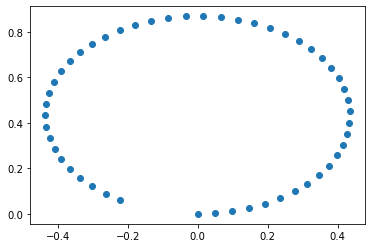

In [8]:
# Simulate driving with the new drive function

num_steps = 50
cur_pos = (0,0)
cur_angle = 0
positions = [cur_pos]
orientations = [cur_angle]
dt = 0.1 # time step in seconds
wheel_dist = 0.2 # distance between left and right wheels in meters, i.e., 2L
wheel_radius = 0.03 # radius of the wheels in meters, i.e., R

for _ in range(num_steps):
    v = 0.5 # in turns/sec
    w = 1.15 # in turns/sec
    cur_pos, cur_angle = drive(cur_pos, cur_angle, v, w, wheel_dist, wheel_radius, dt)
    positions.append(cur_pos)
    orientations.append(cur_angle)

# Plot resulting trajectory

xs, ys = zip(*positions)
plt.scatter(xs,ys)
plt.show()

Seems like the new drive function works as expected. Now let's implement a PID controller!

**EXAMPLE: controlling robot from (0,0) at $0^{\circ}$ to reach $y = 0.05$**

Consider a robot at $(x,y)=(0,0)$ with $0^{\circ}$ yaw angle. Assuming the robot is moving with a constant velocity $v = 0.1$m/s, design a PID controller for angular velocity $\omega$ that can make the robot to reach $y = 0.05$ within 100 time steps where $dt = 0.1$.

<figure>
  <div style="text-align:center;">
  <img src="assets/03/pid_1.png">
  </div>
</figure>

In [9]:
cur_pos = np.array([0,0]) # initial position of the robot
cur_angle = 0 # initial yaw angle of the robot
dt = 0.1 # time step in seconds
num_steps = 100 # max number of time steps
wheel_dist = 0.2 # distance between left and right wheels in meters, i.e., 2L
wheel_radius = 0.03 # radius of the wheels in meters, i.e., R

v = 0.1 # assume velocity is constant in m/s
yt = 0.05 # target

last_e = 0 # to keep track of derivative of error term (starts at 0)
int_e = 0 # to keep track of integral of error term (starts at 0)
xs = [cur_pos[0]] # to store x-position at each time step
ys = [cur_pos[1]] # to store y-position at each time step
ws = [] # to store angular velocity at each time step
es = [] # to store error at each time step

# TODO: modify these gains
kp = 10.0 # proportional gain
ki = 0.0 # integral gain
kd = 100.0 # derivative gain

for i in range(num_steps):
    # compute error (i.e., proportional term)
    e = yt - cur_pos[1] 
    
    # TODO: difference in error from the last time step (i.e., derivative term)
    diff_e = e - last_e #don t need constant because it will be absorbed
    
    # TODO: accumulate error over time for the integral term (i.e., integral term)
    int_e = int_e + e
    
    # compute angular velocity with PID controller
    w = kp * e + ki * int_e + kd * diff_e 
    
    # simulate driving
    cur_pos, cur_angle = drive(cur_pos, cur_angle, v, w, wheel_dist, wheel_radius, dt) 
    
    # update error from last time step
    last_e = e.copy()
    
    # store trajectory, angular velocity, and error so we can plot them
    xs.append(cur_pos[0])
    ys.append(cur_pos[1])
    ws.append(w)
    es.append(e)

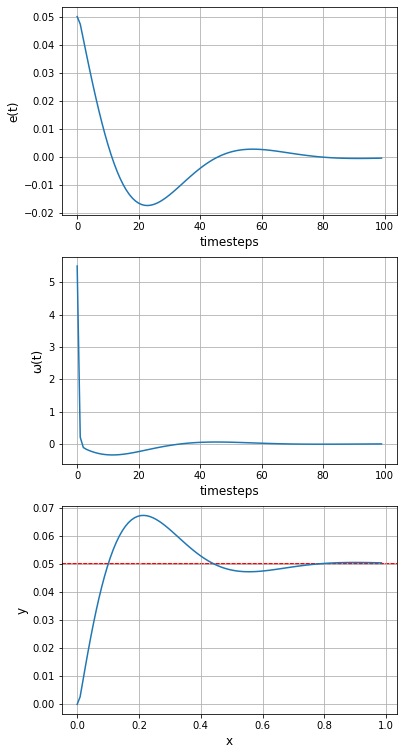

In [10]:
plt.figure(figsize=(6,13))

# Plot error over time
plt.subplot(311)
plt.plot(es)
plt.grid('on')
# plt.ylim(-0.025, 0.055)
plt.xlabel('timesteps', fontsize=12)
plt.ylabel('e(t)', fontsize=12)

# Plot w over time
plt.subplot(312)
plt.plot(ws)
plt.grid('on')
# plt.ylim(-0.5, 0.5)
plt.xlabel('timesteps', fontsize=12)
plt.ylabel('ω(t)', fontsize=12)

# Plot (x,y) position
plt.subplot(313)
plt.grid('on')
plt.plot(xs, ys)
plt.arrow(-10, yt, dx=100, dy=0, width=0.0000001, head_length=0.1, linestyle='--', color='red')
# plt.ylim(-0.05, 0.1)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.show()

# Pure pursuit controller

Pure pursuit controller is a geometric-based controller for path following. Given a reference path, pure pursuit controller uses a follow point (or look-ahead point) located ahead of the robot on the reference path. The idea is then to compute the steering commands that the robot needs to move towards this point (i.e., the robot should intersect the point if the steeting commands is fixed for some time). We can compute the control command that will move the robot towards the follow point as shown in class:

$$
\omega = \frac{2 v_r \sin(\alpha)}{L},
$$

where $L$ denotes the look-ahead distance (i.e., distance between the robot and the follow point), $\alpha$ denotes the angle between the robot heading and the look-ahead line (i.e., the line that goes from the robot to the follow point), and $v_r$ denotes the linear velocity of the robot which can be constant, or scaled according to $\alpha$. As $L$ gets larger, the controller will be more inclined to cut corners to reach the target. In contrast, if $L$ is too small, the controller can cause the vehicle to overshoot and oscilattes around the reference trajectory (we will see this concretely later in the example below).

<figure>
  <div style="text-align:center;">
  <img src="assets/03/pure_pursuit_illustration.png">
  <figcaption>Illustration of pure pursuit controller. Here, the orange and green dots illustrate the robot and the follow point (or look-ahead point), respectively.</figcaption>
  </div>
</figure>

Since the angular velocity is sensitive to $\alpha$ as linear velocity increases, one thing that is often useful is to scale $L$ with $v_r$. That is, we can write $L = K v_r$ where $K$ denotes a gain that we need to tune. This simplifies the computation of $\omega$:

$$
\omega = \frac{\sin(\alpha)}{K}
$$

Note that since this is derived using only kinematics model, there are cases in the real world where this controller does not perform well (e.g., due to non-slipping assumption).

**EXAMPLE: controlling robot from (0,0) at $135^{\circ}$ to reach $y = 0.05$**

Consider a robot at $(x,y)=(0,0)$ with $135^{\circ}$ yaw angle. Assuming the robot is moving with a constant velocity $v = 0.1$m/s, design a pure pursuit controller for angular velocity $\omega$ that can make the robot to reach $y = 0.05$ within 100 time steps where $dt = 0.1$.

<figure>
  <div style="text-align:center;">
  <img src="assets/03/pp_1.png">
  </div>
</figure>

In [25]:
def pure_pursuit(follow_point, K=0.1):
    """
    Input:
        - follow_point: numpy array of follow point [x,y] in robot frame
        - K: controller gain
    Return:
        - v: linear velocity in m/s (float)
        - w: angular velocity in rad/s (float)
    """
    
    # compute distance between robot and follow point
    d = np.sqrt(follow_point[0] ** 2 + follow_point[1] ** 2)
    
    # TODO: compute sin(alpha)
    sin_alpha = follow_point[1] / d
    
    v = 0.1 # we can make it constant or we can make it as a function of sin_alpha
    
    # TODO: compute angular velocity
    w =  sin_alpha / K
    
    return v, w

In [26]:
cur_pos = np.array([0,0]) # initial position of the robot
cur_angle = 135 # initial yaw angle of the robot
dt = 0.1 # time step in seconds
num_steps = 100 # max number of time steps
wheel_dist = 0.2 # distance between left and right wheels in meters, i.e., 2L
wheel_radius = 0.03 # radius of the wheels in meters, i.e., R

v = 0.1 # assume velocity is constant in m/s
yt = 0.05 # target

xs = [cur_pos[0]] # to store x-position at each time step
ys = [cur_pos[1]] # to store y-position at each time step
ws = [] # to store angular velocity at each time step

# Pure pursuit parameters
K = 0.2
follow_x_dist = 0.07 # too large -> cuts corner, too small -> oscillates

for i in range(num_steps):
    robot_x_global = cur_pos[0]
    robot_y_global = cur_pos[1]
    follow_x_global = robot_x_global + follow_x_dist
    follow_y_global = yt
    
    T_or = np.array([
        [np.cos(np.deg2rad(cur_angle)), -np.sin(np.deg2rad(cur_angle)), robot_x_global],
        [np.sin(np.deg2rad(cur_angle)), np.cos(np.deg2rad(cur_angle)), robot_y_global],
        [0, 0, 1]
    ]) # Transformation matrix from origin to robot
    
    T_of = np.array([
        [1, 0, follow_x_global],
        [0, 1, follow_y_global],
        [0, 0, 1]
    ]) # Transformation matrix from origin to follow point
    
    T_rf = np.dot(np.linalg.inv(T_or), T_of) # Transformation matrix from robot to follow point
    
    follow_point_local = np.array([T_rf[0,2], T_rf[1,2]]) # follow point in robot grame
    
    v, w = pure_pursuit(follow_point_local, K=K)
    
    cur_pos, cur_angle = drive(cur_pos, cur_angle, v, w, wheel_dist, wheel_radius, dt) # simulate driving
    
    xs.append(cur_pos[0])
    ys.append(cur_pos[1])
    ws.append(w)

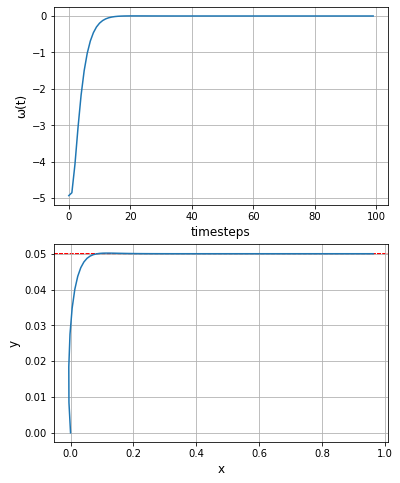

In [27]:
plt.figure(figsize=(6,8))

# Plot w over time
plt.subplot(211)
plt.plot(ws)
plt.grid('on')
# plt.ylim(-0.5, 0.5)
plt.xlabel('timesteps', fontsize=12)
plt.ylabel('ω(t)', fontsize=12)

# Plot (x,y) position
plt.subplot(212)
plt.grid('on')
plt.plot(xs, ys)
plt.arrow(-10, yt, dx=100, dy=0, width=0.0000001, head_length=0.1, linestyle='--', color='red')
# plt.ylim(-0.05, 0.1)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.show()